# testing otpimizations

<a href="https://colab.research.google.com/github/inspektral/onset-benchmark/blob/main/nmf-test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


In [ ]:
import os

if 'google.colab' in str(get_ipython()):
    repo_name = 'onset-benchmark'
    repo_path = f'/content/{repo_name}'
    
    # Check if the current working directory is already the repo
    if os.getcwd() != repo_path:
        if not os.path.exists(repo_path):
            !git clone https://github.com/inspektral/onset-benchmark.git
        os.chdir(repo_path)  # Change to the repository directory
        !pip install -r requirements.txt  # Install dependencies
        !git clone https://github.com/inspektral/music2latent.git

In [90]:
import numpy as np
import matplotlib.pyplot as plt

import synth
from IPython.display import Audio, display
import librosa

import utils

In [91]:
import ipywidgets as widgets
from IPython.display import display
import test_signals
import utils

TEST = "sines_noise"
REPR = "music2latent"
METRIC = "magnitude"

# Collect callable test functions from test_signals
tests = {name: obj for name, obj in vars(test_signals).items() if callable(obj)}

# Create dropdowns
test_dropdown = widgets.Dropdown(
    options=list(tests.keys()),
    value=TEST,
    description="Test:",
)

repr_dropdown = widgets.Dropdown(
    options=utils.get_available_representations(),
    value=REPR,
    description="Repr:",
)

metric_dropdown = widgets.Dropdown(
    options=utils.get_available_metrics(),
    value=METRIC,
    description="Metric:",
)

# Display widgets
display(test_dropdown, repr_dropdown, metric_dropdown)

# Optional: Access selected values
def on_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        print(f"Selected: TEST = {test_dropdown.value}, REPR = {repr_dropdown.value}, METRIC = {metric_dropdown.value}")
        global TEST, REPR, METRIC
        TEST = test_dropdown.value
        REPR = repr_dropdown.value
        METRIC = metric_dropdown.value

test_dropdown.observe(on_change)
repr_dropdown.observe(on_change)
metric_dropdown.observe(on_change)


Dropdown(description='Test:', index=4, options=('square_slow', 'square_fast', 'square_vibrato', 'saw_noise', '…

Dropdown(description='Repr:', index=3, options=('mfcc', 'cqt', 'spectrum', 'music2latent', 'dac'), value='musi…

Dropdown(description='Metric:', options=('magnitude', 'distances', 'cosine_similarity'), value='magnitude')

Selected: TEST = reverb_noise, REPR = music2latent, METRIC = magnitude


/home/inspektral/miniconda3/envs/mir/lib/python3.10/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


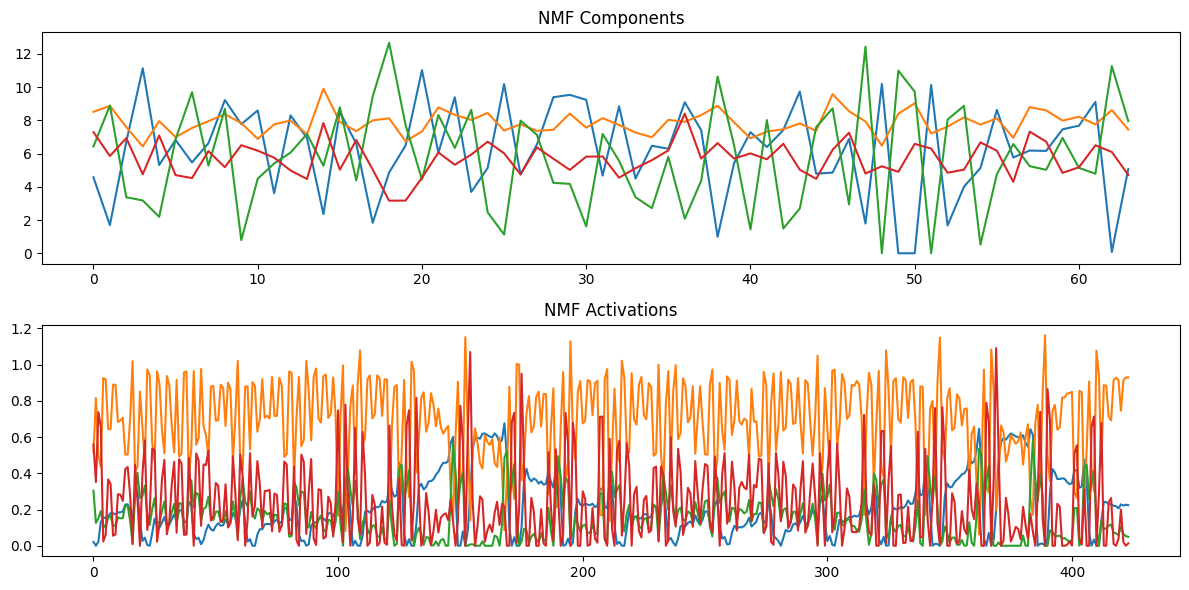

In [97]:
audio, modulator = tests[TEST]()
length = int(len(modulator) / 10)

def norm_stretch(arr, length):
    arr = utils.norm(arr)
    arr = utils.stretch_array(arr, length)
    return arr

modulator = norm_stretch(modulator, length)
repr = utils.calc_representation(audio, REPR)
minimum = np.abs(np.min(repr))
repr = repr + minimum

# NMF
import librosa

components, activations = librosa.decompose.decompose(
    repr+minimum,
    n_components=4,
    sort=True,
    random_state=42
)

display(Audio(audio, rate=44100))

plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(components)
plt.title('NMF Components')
plt.subplot(2, 1, 2)
plt.plot(activations.T)
plt.title('NMF Activations')
plt.tight_layout()
plt.show()

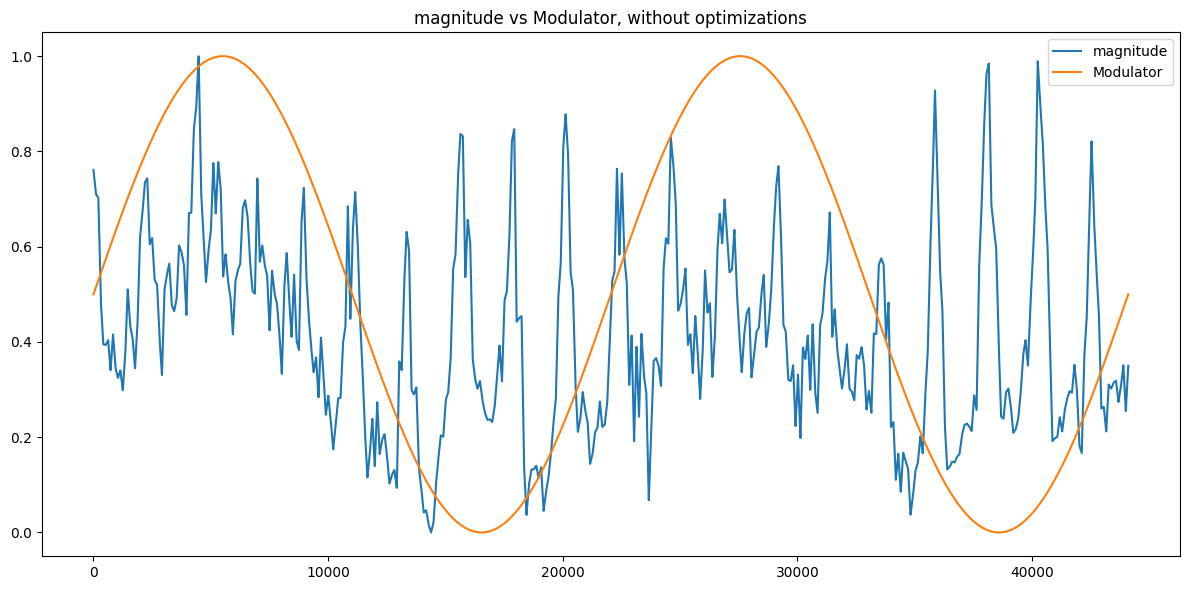

In [98]:
metric = utils.calc_metric(repr, METRIC)
metric = utils.norm_stretch(metric, length)

plt.figure(figsize=(12, 6))
plt.plot(metric, label=METRIC)
plt.plot(modulator, label='Modulator')
plt.title(f'{METRIC} vs Modulator, without optimizations')
plt.legend()
plt.tight_layout()
plt.show()

Best exponent: 0.13464811654193445
Best smooth: 4816
Correlation between modulator and magnitude: 0.7638


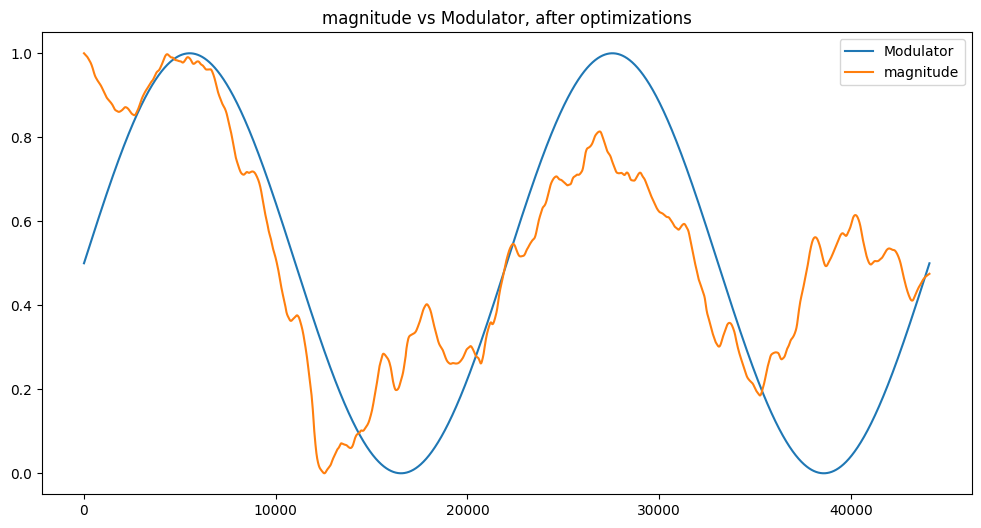

In [99]:
best_exponent = utils.calc_best_exponent(metric, modulator)
print(f"Best exponent: {best_exponent}")
metric = utils.norm(metric ** best_exponent)

best_smooth = utils.calc_best_smoothing(metric, modulator)
print(f"Best smooth: {best_smooth}")
metric = utils.norm(utils.smooth(metric, best_smooth))
correlation = utils.calc_correlation(modulator, metric)
print(f"Correlation between modulator and magnitude: {correlation:.4f}")

plt.figure(figsize=(12, 6))
plt.plot(modulator, label='Modulator')
plt.plot(metric, label=METRIC)
plt.title(f'{METRIC} vs Modulator, after optimizations')
plt.legend()
plt.show()



Activation 0 correlation: -0.9313
Activation 1 correlation: 0.7141
Activation 2 correlation: 0.8563
Activation 3 correlation: 0.4737
Best activation index: 0 with correlation 0.9313


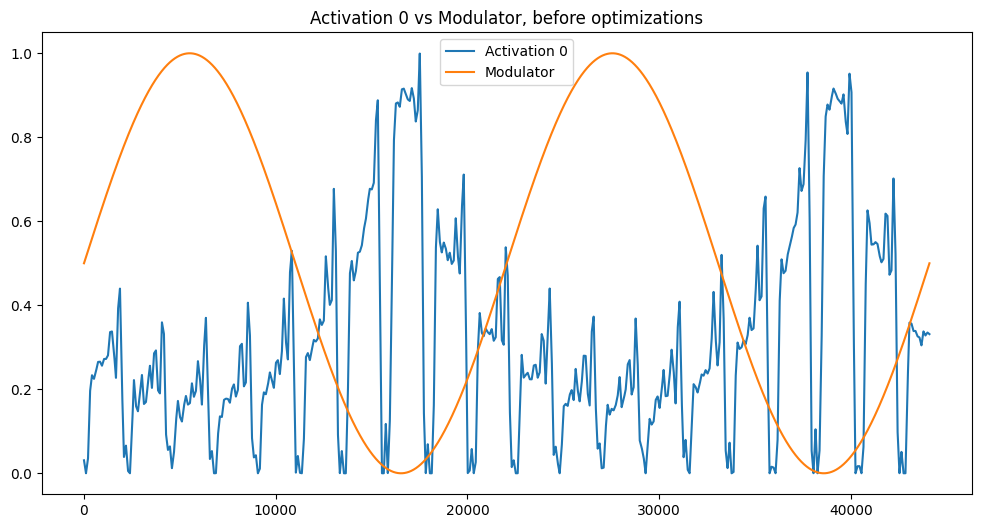

In [100]:
correlations = []

for i in range(activations.shape[0]):
    activation = norm_stretch(activations[i], length)
    activation = utils.smooth(activation, best_smooth)
    activation = norm_stretch(activation, length)
    correlation = utils.calc_correlation(modulator, activation)
    correlations.append(np.abs(correlation))
    print(f"Activation {i} correlation: {correlation:.4f}")

best_index = np.argmax(correlations)
print(f"Best activation index: {best_index} with correlation {correlations[best_index]:.4f}")
activation = norm_stretch(activations[best_index], length)



plt.figure(figsize=(12, 6))
plt.plot(activation, label=f'Activation {best_index}')
plt.plot(modulator, label='Modulator')
plt.title(f'Activation {best_index} vs Modulator, before optimizations')
plt.legend()
plt.show()

/home/inspektral/miniconda3/envs/mir/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [5000] before, using random point [857]
  warnings.warn(
/home/inspektral/miniconda3/envs/mir/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [5000] before, using random point [486]
  warnings.warn(
/home/inspektral/miniconda3/envs/mir/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [5000] before, using random point [3441]
  warnings.warn(


Best smooth for activation 0: 4999
Correlation between modulator and activation 0: -0.9314


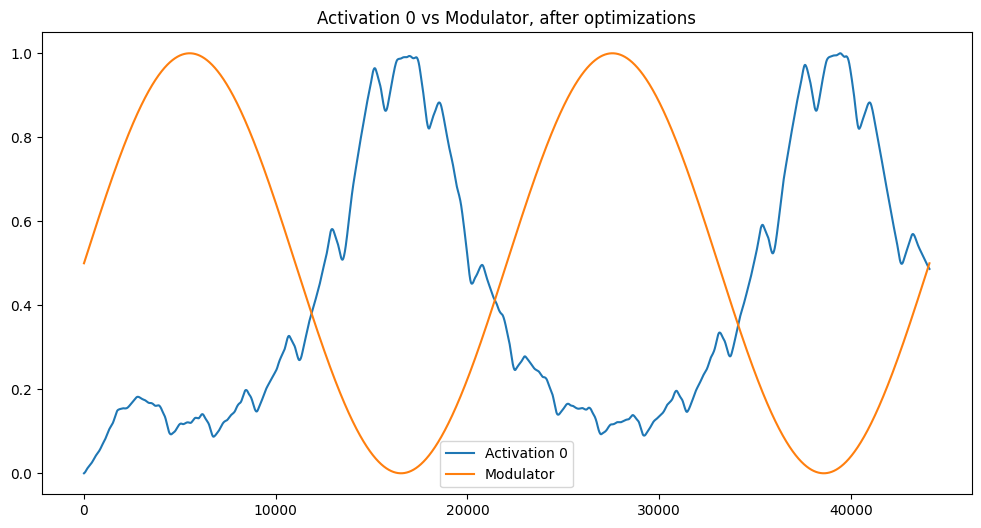

In [101]:
best_smooth = utils.calc_best_smoothing(activation, modulator)
print(f"Best smooth for activation {best_index}: {best_smooth}")
activation = utils.norm(utils.smooth(activation, best_smooth))
correlation = utils.calc_correlation(modulator, activation)
print(f"Correlation between modulator and activation {best_index}: {correlation:.4f}")


plt.figure(figsize=(12, 6))
plt.plot(activation, label=f'Activation {best_index}')
plt.plot(modulator, label='Modulator')
plt.title(f'Activation {best_index} vs Modulator, after optimizations')
plt.legend()
plt.show()